In [56]:
import os
import glob
import pandas as pd
from pathlib import Path
from scipy import stats
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import numpy as np
from hydra import initialize, compose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import math
import os
import seaborn as sns

from sklearn import metrics, model_selection
from sklearn.preprocessing import scale, normalize
from sklearn import datasets, cluster
from sklearn import neighbors, ensemble, tree, linear_model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from hydra import initialize, compose

In [2]:
initialize('../data/raw_output/cross_val/checkpoints/CROSS_VAL_paper_v1_w_ES/2022-09-16_15:29:25.963345')

hydra.initialize()

In [91]:
from itertools import product

import numpy as np


class ConfusionMatrixDisplay:
    """Confusion Matrix visualization.
    It is recommend to use
    :func:`~sklearn.metrics.ConfusionMatrixDisplay.from_estimator` or
    :func:`~sklearn.metrics.ConfusionMatrixDisplay.from_predictions` to
    create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
    attributes.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    confusion_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix.
    display_labels : ndarray of shape (n_classes,), default=None
        Display labels for plot. If None, display labels are set from 0 to
        `n_classes - 1`.
    Attributes
    ----------
    im_ : matplotlib AxesImage
        Image representing the confusion matrix.
    text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text, \
            or None
        Array of matplotlib axes. `None` if `include_values` is false.
    ax_ : matplotlib Axes
        Axes with confusion matrix.
    figure_ : matplotlib Figure
        Figure containing the confusion matrix.
    See Also
    --------
    confusion_matrix : Compute Confusion Matrix to evaluate the accuracy of a
        classification.
    ConfusionMatrixDisplay.from_estimator : Plot the confusion matrix
        given an estimator, the data, and the label.
    ConfusionMatrixDisplay.from_predictions : Plot the confusion matrix
        given the true and predicted labels.
    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> from sklearn.datasets import make_classification
    >>> from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    >>> from sklearn.model_selection import train_test_split
    >>> from sklearn.svm import SVC
    >>> X, y = make_classification(random_state=0)
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y,
    ...                                                     random_state=0)
    >>> clf = SVC(random_state=0)
    >>> clf.fit(X_train, y_train)
    SVC(random_state=0)
    >>> predictions = clf.predict(X_test)
    >>> cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    >>> disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    ...                               display_labels=clf.classes_)
    >>> disp.plot()
    <...>
    >>> plt.show()
    """

    def __init__(self, confusion_matrix, *, display_labels=None, ylabel='', xlabel=''):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels
        self.xlabel = xlabel
        self.ylabel = ylabel

    def plot(
        self,
        *,
        include_values=True,
        cmap="viridis",
        xticks_rotation="horizontal",
        values_format=None,
        ax=None,
        colorbar=True,
        im_kw=None,
    ):
        """Plot visualization.
        Parameters
        ----------
        include_values : bool, default=True
            Includes values in confusion matrix.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                         default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is 'd' or '.2g' whichever is shorter.
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        colorbar : bool, default=True
            Whether or not to add a colorbar to the plot.
        im_kw : dict, default=None
            Dict with keywords passed to `matplotlib.pyplot.imshow` call.
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        """
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        cm = self.confusion_matrix
        n_classes = cm.shape[0]

        default_im_kw = dict(interpolation="nearest", cmap=cmap)
        im_kw = im_kw or {}
        im_kw = {**default_im_kw, **im_kw}

        self.im_ = ax.imshow(cm, **im_kw)
        self.text_ = None
        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)

            # print text with appropriate color depending on background
            thresh = (cm.max() + cm.min()) / 2.0

            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min

                if values_format is None:
                    text_cm = format(cm[i, j], ".2g")
                    if cm.dtype.kind != "f":
                        text_d = format(cm[i, j], "d")
                        if len(text_d) < len(text_cm):
                            text_cm = text_d
                else:
                    text_cm = format(cm[i, j], values_format)

                self.text_[i, j] = ax.text(
                    j, i, text_cm, ha="center", va="center", color=color
                )

        if self.display_labels is None:
            display_labels = np.arange(n_classes)
        else:
            display_labels = self.display_labels
        if colorbar:
            fig.colorbar(self.im_, ax=ax)
        ax.set(
            xticks=np.arange(n_classes),
            yticks=np.arange(n_classes),
            xticklabels=display_labels,
            yticklabels=display_labels,
            ylabel=self.ylabel,
            xlabel=self.xlabel,
        )

        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

        self.figure_ = fig
        self.ax_ = ax
        return self

    @classmethod
    def from_estimator(
        cls,
        estimator,
        X,
        y,
        *,
        labels=None,
        sample_weight=None,
        normalize=None,
        display_labels=None,
        include_values=True,
        xticks_rotation="horizontal",
        values_format=None,
        cmap="viridis",
        ax=None,
        colorbar=True,
        im_kw=None,
    ):
        """Plot Confusion Matrix given an estimator and some data.
        Read more in the :ref:`User Guide <confusion_matrix>`.
        .. versionadded:: 1.0
        Parameters
        ----------
        estimator : estimator instance
            Fitted classifier or a fitted :class:`~sklearn.pipeline.Pipeline`
            in which the last estimator is a classifier.
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Input values.
        y : array-like of shape (n_samples,)
            Target values.
        labels : array-like of shape (n_classes,), default=None
            List of labels to index the confusion matrix. This may be used to
            reorder or select a subset of labels. If `None` is given, those
            that appear at least once in `y_true` or `y_pred` are used in
            sorted order.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        normalize : {'true', 'pred', 'all'}, default=None
            Either to normalize the counts display in the matrix:
            - if `'true'`, the confusion matrix is normalized over the true
              conditions (e.g. rows);
            - if `'pred'`, the confusion matrix is normalized over the
              predicted conditions (e.g. columns);
            - if `'all'`, the confusion matrix is normalized by the total
              number of samples;
            - if `None` (default), the confusion matrix will not be normalized.
        display_labels : array-like of shape (n_classes,), default=None
            Target names used for plotting. By default, `labels` will be used
            if it is defined, otherwise the unique labels of `y_true` and
            `y_pred` will be used.
        include_values : bool, default=True
            Includes values in confusion matrix.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`, the
            format specification is 'd' or '.2g' whichever is shorter.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        ax : matplotlib Axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        colorbar : bool, default=True
            Whether or not to add a colorbar to the plot.
        im_kw : dict, default=None
            Dict with keywords passed to `matplotlib.pyplot.imshow` call.
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        See Also
        --------
        ConfusionMatrixDisplay.from_predictions : Plot the confusion matrix
            given the true and predicted labels.
        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.metrics import ConfusionMatrixDisplay
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(
        ...         X, y, random_state=0)
        >>> clf = SVC(random_state=0)
        >>> clf.fit(X_train, y_train)
        SVC(random_state=0)
        >>> ConfusionMatrixDisplay.from_estimator(
        ...     clf, X_test, y_test)
        <...>
        >>> plt.show()
        """
        method_name = f"{cls.__name__}.from_estimator"
        if not is_classifier(estimator):
            raise ValueError(f"{method_name} only supports classifiers")
        y_pred = estimator.predict(X)

        return cls.from_predictions(
            y,
            y_pred,
            sample_weight=sample_weight,
            labels=labels,
            normalize=normalize,
            display_labels=display_labels,
            include_values=include_values,
            cmap=cmap,
            ax=ax,
            xticks_rotation=xticks_rotation,
            values_format=values_format,
            colorbar=colorbar,
            im_kw=im_kw,
        )

    @classmethod
    def from_predictions(
        cls,
        y_true,
        y_pred,
        *,
        labels=None,
        sample_weight=None,
        normalize=None,
        display_labels=None,
        include_values=True,
        xticks_rotation="horizontal",
        values_format=None,
        cmap="viridis",
        ax=None,
        colorbar=True,
        im_kw=None,
    ):
        """Plot Confusion Matrix given true and predicted labels.
        Read more in the :ref:`User Guide <confusion_matrix>`.
        .. versionadded:: 1.0
        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            True labels.
        y_pred : array-like of shape (n_samples,)
            The predicted labels given by the method `predict` of an
            classifier.
        labels : array-like of shape (n_classes,), default=None
            List of labels to index the confusion matrix. This may be used to
            reorder or select a subset of labels. If `None` is given, those
            that appear at least once in `y_true` or `y_pred` are used in
            sorted order.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        normalize : {'true', 'pred', 'all'}, default=None
            Either to normalize the counts display in the matrix:
            - if `'true'`, the confusion matrix is normalized over the true
              conditions (e.g. rows);
            - if `'pred'`, the confusion matrix is normalized over the
              predicted conditions (e.g. columns);
            - if `'all'`, the confusion matrix is normalized by the total
              number of samples;
            - if `None` (default), the confusion matrix will not be normalized.
        display_labels : array-like of shape (n_classes,), default=None
            Target names used for plotting. By default, `labels` will be used
            if it is defined, otherwise the unique labels of `y_true` and
            `y_pred` will be used.
        include_values : bool, default=True
            Includes values in confusion matrix.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`, the
            format specification is 'd' or '.2g' whichever is shorter.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        ax : matplotlib Axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        colorbar : bool, default=True
            Whether or not to add a colorbar to the plot.
        im_kw : dict, default=None
            Dict with keywords passed to `matplotlib.pyplot.imshow` call.
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        See Also
        --------
        ConfusionMatrixDisplay.from_estimator : Plot the confusion matrix
            given an estimator, the data, and the label.
        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.metrics import ConfusionMatrixDisplay
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(
        ...         X, y, random_state=0)
        >>> clf = SVC(random_state=0)
        >>> clf.fit(X_train, y_train)
        SVC(random_state=0)
        >>> y_pred = clf.predict(X_test)
        >>> ConfusionMatrixDisplay.from_predictions(
        ...    y_test, y_pred)
        <...>
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_predictions")

        if display_labels is None:
            if labels is None:
                display_labels = unique_labels(y_true, y_pred)
            else:
                display_labels = labels

        cm = confusion_matrix(
            y_true,
            y_pred,
            sample_weight=sample_weight,
            labels=labels,
            normalize=normalize,
        )

        disp = cls(confusion_matrix=cm, display_labels=display_labels)

        return disp.plot(
            include_values=include_values,
            cmap=cmap,
            ax=ax,
            xticks_rotation=xticks_rotation,
            values_format=values_format,
            colorbar=colorbar,
            im_kw=im_kw,
        )

    def plot_confusion_matrix(
        estimator,
        X,
        y_true,
        *,
        labels=None,
        sample_weight=None,
        normalize=None,
        display_labels=None,
        include_values=True,
        xticks_rotation="horizontal",
        values_format=None,
        cmap="viridis",
        ax=None,
        colorbar=True,
    ):
        """Plot Confusion Matrix.
        `plot_confusion_matrix` is deprecated in 1.0 and will be removed in
        1.2. Use one of the following class methods:
        :func:`~sklearn.metrics.ConfusionMatrixDisplay.from_predictions` or
        :func:`~sklearn.metrics.ConfusionMatrixDisplay.from_estimator`.
        Read more in the :ref:`User Guide <confusion_matrix>`.
        Parameters
        ----------
        estimator : estimator instance
            Fitted classifier or a fitted :class:`~sklearn.pipeline.Pipeline`
            in which the last estimator is a classifier.
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Input values.
        y_true : array-like of shape (n_samples,)
            Target values.
        labels : array-like of shape (n_classes,), default=None
            List of labels to index the matrix. This may be used to reorder or
            select a subset of labels. If `None` is given, those that appear at
            least once in `y_true` or `y_pred` are used in sorted order.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.
        normalize : {'true', 'pred', 'all'}, default=None
            Either to normalize the counts display in the matrix:
                - if `'true'`, the confusion matrix is normalized over the true
                  conditions (e.g. rows);
                - if `'pred'`, the confusion matrix is normalized over the
                  predicted conditions (e.g. columns);
                - if `'all'`, the confusion matrix is normalized by the total
                  number of samples;
                - if `None` (default), the confusion matrix will not be normalized.
        display_labels : array-like of shape (n_classes,), default=None
            Target names used for plotting. By default, `labels` will be used if
            it is defined, otherwise the unique labels of `y_true` and `y_pred`
            will be used.
        include_values : bool, default=True
            Includes values in confusion matrix.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                            default='horizontal'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is 'd' or '.2g' whichever is shorter.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        ax : matplotlib Axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        colorbar : bool, default=True
            Whether or not to add a colorbar to the plot.
            .. versionadded:: 0.24
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
            Object that stores computed values.
        See Also
        --------
        confusion_matrix : Compute Confusion Matrix to evaluate the accuracy of a
            classification.
        ConfusionMatrixDisplay : Confusion Matrix visualization.
        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.metrics import plot_confusion_matrix
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn.svm import SVC
        >>> X, y = make_classification(random_state=0)
        >>> X_train, X_test, y_train, y_test = train_test_split(
        ...         X, y, random_state=0)
        >>> clf = SVC(random_state=0)
        >>> clf.fit(X_train, y_train)
        SVC(random_state=0)
        >>> plot_confusion_matrix(clf, X_test, y_test)  # doctest: +SKIP
        >>> plt.show()
        """

        if not is_classifier(estimator):
            raise ValueError("plot_confusion_matrix only supports classifiers")

        y_pred = estimator.predict(X)
        cm = confusion_matrix(
            y_true, y_pred, sample_weight=sample_weight, labels=labels, normalize=normalize
        )

        if display_labels is None:
            if labels is None:
                display_labels = unique_labels(y_true, y_pred)
            else:
                display_labels = labels

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        return disp.plot(
            include_values=include_values,
            cmap=cmap,
            ax=ax,
            xticks_rotation=xticks_rotation,
            values_format=values_format,
            colorbar=colorbar,
        )

In [92]:
cfg = compose(config_name='config.yaml')

In [93]:
def dataframe_preproc( df, columns=[] ):
    df.Prognosis.replace('SEVERE', 1, inplace=True)
    df.Prognosis.replace('MILD', 0, inplace=True)
    X_df = df.drop( columns=['ImageFile', 'Prognosis', 'Death'])    
    
    y = df[ ['Prognosis', 'Death'] ].values
        
    if len(columns) > 0:
        X_df = X_df[best_cols] # restrict to certain columns only
    
    X = X_df.values
    X_features = X_df.columns
        
    return X, y, X_features

def load_cv_data( cv=1, dataset='population_average', columns=[], include_death_column=False ):
    train_cv_df = pd.read_csv( cfg.datasets[dataset].cv_train_table+'cv'+str(cv)+'.csv')
    valid_cv_df = pd.read_csv( cfg.datasets[dataset].cv_valid_table+'cv'+str(cv)+'.csv')
    test_df = pd.read_csv(cfg.datasets[dataset].test_table)
    
    whole_test_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/completeTestClinData.xls')
    test_raw_df = whole_test_df[ ['ImageFile', 'Prognosis'] ]
    test_raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
    test_raw_df.Prognosis.replace('MILD', 0, inplace=True)
    
    test_df.Prognosis = test_raw_df.Prognosis

    x_train, y_train, features_train = dataframe_preproc( train_cv_df, columns )
    x_valid, y_valid, features_valid = dataframe_preproc( valid_cv_df, columns )
    x_test, y_test, features_test = dataframe_preproc(test_df, columns)

    if include_death_column:
         return x_train, y_train, x_valid, y_valid, x_test, y_test
        
    else:
        # keep prognosis only
        y_train = y_train[:,0]
        y_valid = y_valid[:,0]
        y_test = y_test[:, 0]

        #print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)
        return x_train, y_train, x_valid, y_valid, x_test, y_test
    
models_to_run = { 'Logistic': linear_model.LogisticRegression, 'XGB': XGBClassifier}

In [94]:
cross_val_predictions = {model_name: { fold: [] for fold in range(1, 6)} for model_name in models_to_run.keys()}

for model_name, model in models_to_run.items():
    print(f'Cross-validating the {model_name} model')
    print('Fold:\t', end='')
    for fold in range(1,6):
        model_instance = model(n_jobs=8) if model_name == "Logistic" else model(n_jobs=8, eval_metric='error')
        print(f'{fold}', end=',   ')
        x_train, y_train, x_valid, y_valid, x_test, y_test = load_cv_data(fold, 'population_average', [])
        model_instance.fit(x_train, y_train)
        pred_values_label = model_instance.predict(x_valid)
        cross_val_predictions[model_name][fold] = model_instance.predict(x_valid).tolist()
    print('')

Cross-validating the Logistic model
Fold:	1,   2,   3,   4,   5,   
Cross-validating the XGB model
Fold:	1,   2,   3,   4,   5,   


In [95]:
def run_cv_analysis(base_path, cross_val_predictions):
    paths = list(filter(lambda x: x is not None, [path if path.is_dir() else None for path in\
         Path(base_path).iterdir()]))

    file = pd.read_csv(paths[0] / 'pred_valid.csv').file

    cols = ["file"]
    cols.extend([f"nn_prognosis_{ind + 1}" for ind in range(len(list(paths)))])
    preds = pd.DataFrame(columns=cols)

    preds["file"] = file

    for _, path_dir in enumerate(paths):
        try:
            fold = int(open(os.path.join(path_dir, "fold"), "r").readline()) + 1

            pred = pd.read_csv(path_dir / 'pred_valid.csv')
            preds[f"nn_prognosis_{fold}"] = pred.prognosis
            preds[f"nn_prognosis_{fold}"].replace('SEVERE', 1, inplace=True)
            preds[f"nn_prognosis_{fold}"].replace('MILD', 0, inplace=True)
            
            preds[f"prognosis_{fold}_real"] = pred["prognosis_real"]
            preds[f"prognosis_{fold}_real"].replace('SEVERE', 1, inplace=True)
            preds[f"prognosis_{fold}_real"].replace('MILD', 0, inplace=True)
            
            for model, folds in cross_val_predictions.items():
                preds[f"{model.lower()}_prognosis_{fold}"] = folds[fold]
            
        except Exception:
            print('?')
            continue
    
    return preds

In [96]:
progs = run_cv_analysis('../data/raw_output/cross_val/checkpoints_image_only/', cross_val_predictions)

In [97]:
progs.head()

,file,nn_prognosis_1,nn_prognosis_2,nn_prognosis_3,nn_prognosis_4,nn_prognosis_5,prognosis_1_real,logistic_prognosis_1,xgb_prognosis_1,prognosis_4_real,...,xgb_prognosis_4,prognosis_5_real,logistic_prognosis_5,xgb_prognosis_5,prognosis_2_real,logistic_prognosis_2,xgb_prognosis_2,prognosis_3_real,logistic_prognosis_3,xgb_prognosis_3
0,P_2_70.png,1,0,0,1,1,0,0,1,1,...,1,1,1,1,0,1,0,0,0,0
1,P_1_54.png,1,0,1,1,0,1,1,1,0,...,0,1,0,1,1,0,0,1,1,1
2,P_827.png,1,0,1,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
3,P_570.png,0,1,0,1,1,1,0,1,1,...,1,0,0,0,1,1,1,0,0,0
4,P_504.png,1,0,1,1,1,0,0,0,0,...,1,1,1,1,0,0,0,1,1,1


In [105]:
False == 0

True

In [152]:
def run_analysis(progs):
    cf_matrices = {"nn_xgb": [], "nn_log": [], "xgb_log": []}

    for fold in range(1, 6):
        print('FOLD:', fold)
        nn = progs[f"nn_prognosis_{fold}"].values
        logistic = progs[f"logistic_prognosis_{fold}"].values
        xgb = progs[f"xgb_prognosis_{fold}"].values
        true = progs[f"prognosis_{fold}_real"].values

        indicies_logistic_and_true_match = set(np.nonzero(np.ones_like(true) - true - logistic)[0].tolist())
        indicies_xgb_and_true_match = set(np.nonzero(np.ones_like(true) - true - xgb)[0].tolist())
        indicies_nn_and_true_match = set(np.nonzero(np.ones_like(true) - true - nn)[0].tolist())

        indicies_nn_and_logistic_match = set(np.nonzero(np.ones_like(nn) - nn - logistic)[0].tolist())
        indicies_nn_and_xgb_match = set(np.nonzero(np.ones_like(nn) - nn - xgb)[0].tolist())
        indicies_logistic_and_xgb_match = set(np.nonzero(np.ones_like(logistic) - logistic - xgb)[0].tolist())

        print('NN overlap with TRUE', len(indicies_nn_and_true_match)/len(true))
        print('LOGISTIC overlap with TRUE', len(indicies_logistic_and_true_match)/len(true))
        print('XGB overlap with TRUE', len(indicies_xgb_and_true_match)/len(true))
        print('XGB overlap with NN', len(indicies_nn_and_xgb_match)/ len(true))
        print('LOGISTIC overlap with NN', len(indicies_nn_and_logistic_match)/ len(true))
        print('LOGISTIC overlap with XGB', len(indicies_logistic_and_xgb_match)/len(true))

        nn_matches_true = np.abs(np.ones_like(true) - true - nn)
        xgb_matches_true = np.abs(np.ones_like(true) - true - xgb)
        logistic_matches_true = np.abs(np.ones_like(true) - true - logistic)

        nn_xgb = confusion_matrix(xgb_matches_true, nn_matches_true, normalize='all')
        nn_logistic = confusion_matrix(logistic_matches_true, nn_matches_true, normalize='all')
        xgb_logistic = confusion_matrix(logistic_matches_true, xgb_matches_true, normalize='all')

        cf_matrices["nn_xgb"].append(nn_xgb)
        cf_matrices["nn_log"].append(nn_logistic)
        cf_matrices["xgb_log"].append(xgb_logistic)

        print('\n\n')

    fig, axes = plt.subplots(1, 3, figsize=(40, 10))
    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["nn_xgb"], axis=0),
                                  display_labels=['0', '1'], xlabel='NN matches TRUE',
                                  ylabel='XGB matches TRUE')
    disp.plot(values_format='.3f', ax=axes[0], cmap="Greens", include_values=False)

    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["nn_log"], axis=0),
                                  display_labels=['0', '1'], xlabel='NN matches TRUE',
                                  ylabel='LOGISTIC matches TRUE')
    disp.plot(values_format='.3f', ax=axes[1], cmap="Greens", include_values=False)

    disp = ConfusionMatrixDisplay(np.mean(cf_matrices["xgb_log"], axis=0), 
                                  display_labels=['0', '1'], xlabel='XGB matches TRUE',
                                  ylabel='LOGISTIC matches TRUE')
    disp.plot(values_format='.3f', ax=axes[2], cmap="Greens", include_values=False)
    plt.show()

FOLD: 1
NN overlap with TRUE 0.6470588235294118
LOGISTIC overlap with TRUE 0.7330316742081447
XGB overlap with TRUE 0.7963800904977375
XGB overlap with NN 0.6425339366515838
LOGISTIC overlap with NN 0.6606334841628959
LOGISTIC overlap with XGB 0.7918552036199095



FOLD: 2
NN overlap with TRUE 0.6018099547511312
LOGISTIC overlap with TRUE 0.7420814479638009
XGB overlap with TRUE 0.7647058823529411
XGB overlap with NN 0.6289592760180995
LOGISTIC overlap with NN 0.669683257918552
LOGISTIC overlap with XGB 0.7782805429864253



FOLD: 3
NN overlap with TRUE 0.6877828054298643
LOGISTIC overlap with TRUE 0.7601809954751131
XGB overlap with TRUE 0.7285067873303167
XGB overlap with NN 0.6787330316742082
LOGISTIC overlap with NN 0.6923076923076923
LOGISTIC overlap with XGB 0.832579185520362



FOLD: 4
NN overlap with TRUE 0.497737556561086
LOGISTIC overlap with TRUE 0.7194570135746606
XGB overlap with TRUE 0.755656108597285
XGB overlap with NN 0.5429864253393665
LOGISTIC overlap with NN 0.47058

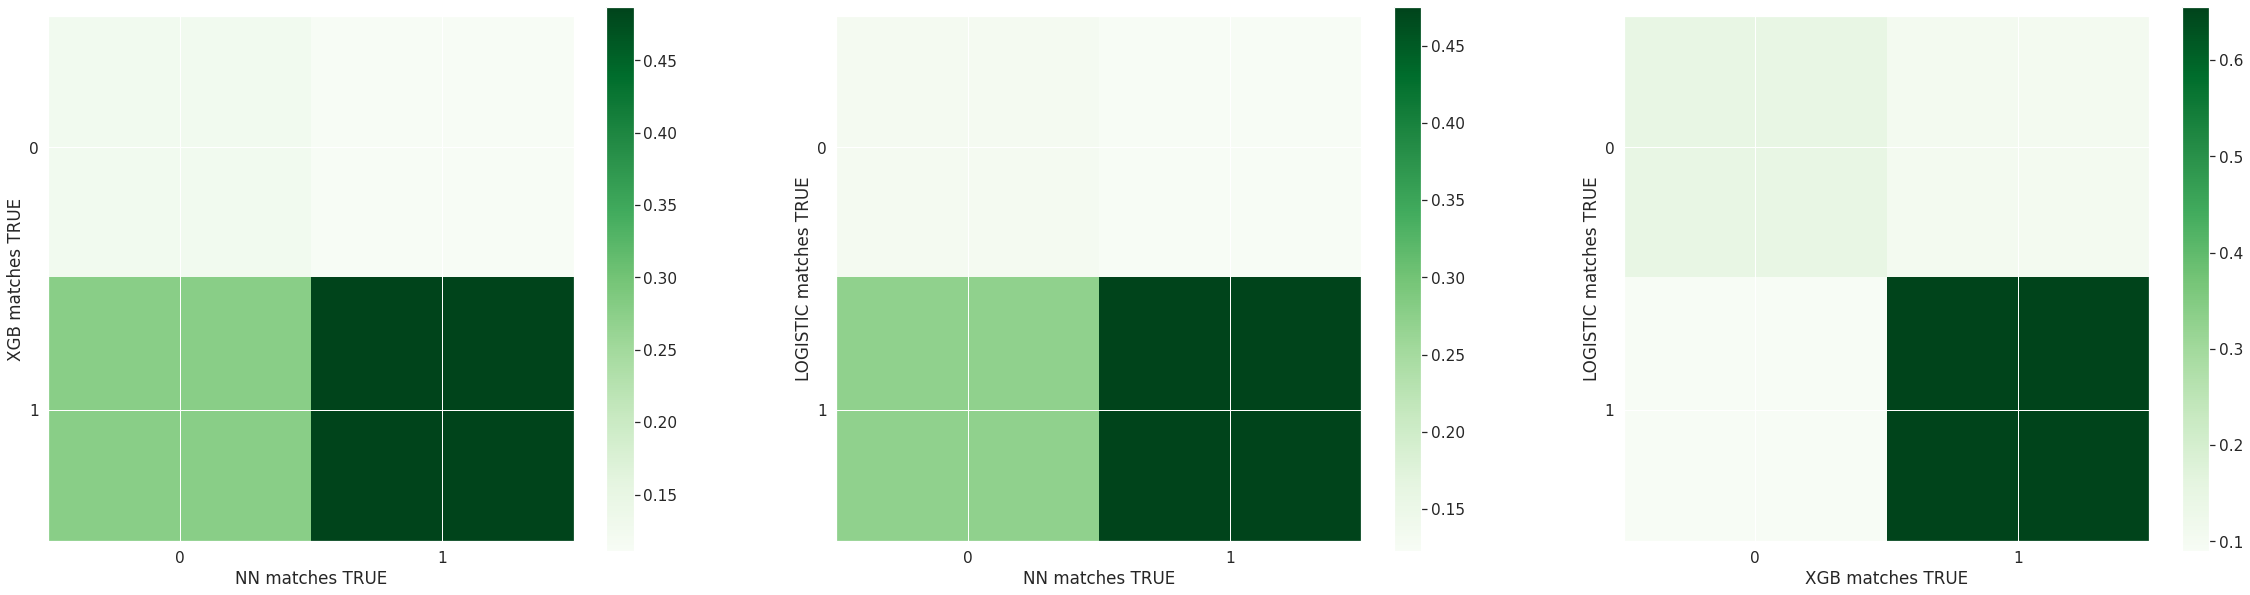

In [153]:
run_analysis(progs)

FOLD: 1
NN overlap with TRUE 0.7647058823529411
LOGISTIC overlap with TRUE 0.7330316742081447
XGB overlap with TRUE 0.7963800904977375
XGB overlap with NN 0.8144796380090498
LOGISTIC overlap with NN 0.8144796380090498
LOGISTIC overlap with XGB 0.7918552036199095



FOLD: 2
NN overlap with TRUE 0.751131221719457
LOGISTIC overlap with TRUE 0.7420814479638009
XGB overlap with TRUE 0.7647058823529411
XGB overlap with NN 0.8597285067873304
LOGISTIC overlap with NN 0.8371040723981901
LOGISTIC overlap with XGB 0.7782805429864253



FOLD: 3
NN overlap with TRUE 0.7963800904977375
LOGISTIC overlap with TRUE 0.7601809954751131
XGB overlap with TRUE 0.7285067873303167
XGB overlap with NN 0.8235294117647058
LOGISTIC overlap with NN 0.8642533936651584
LOGISTIC overlap with XGB 0.832579185520362



FOLD: 4
NN overlap with TRUE 0.7330316742081447
LOGISTIC overlap with TRUE 0.7194570135746606
XGB overlap with TRUE 0.755656108597285
XGB overlap with NN 0.7601809954751131
LOGISTIC overlap with NN 0.8054

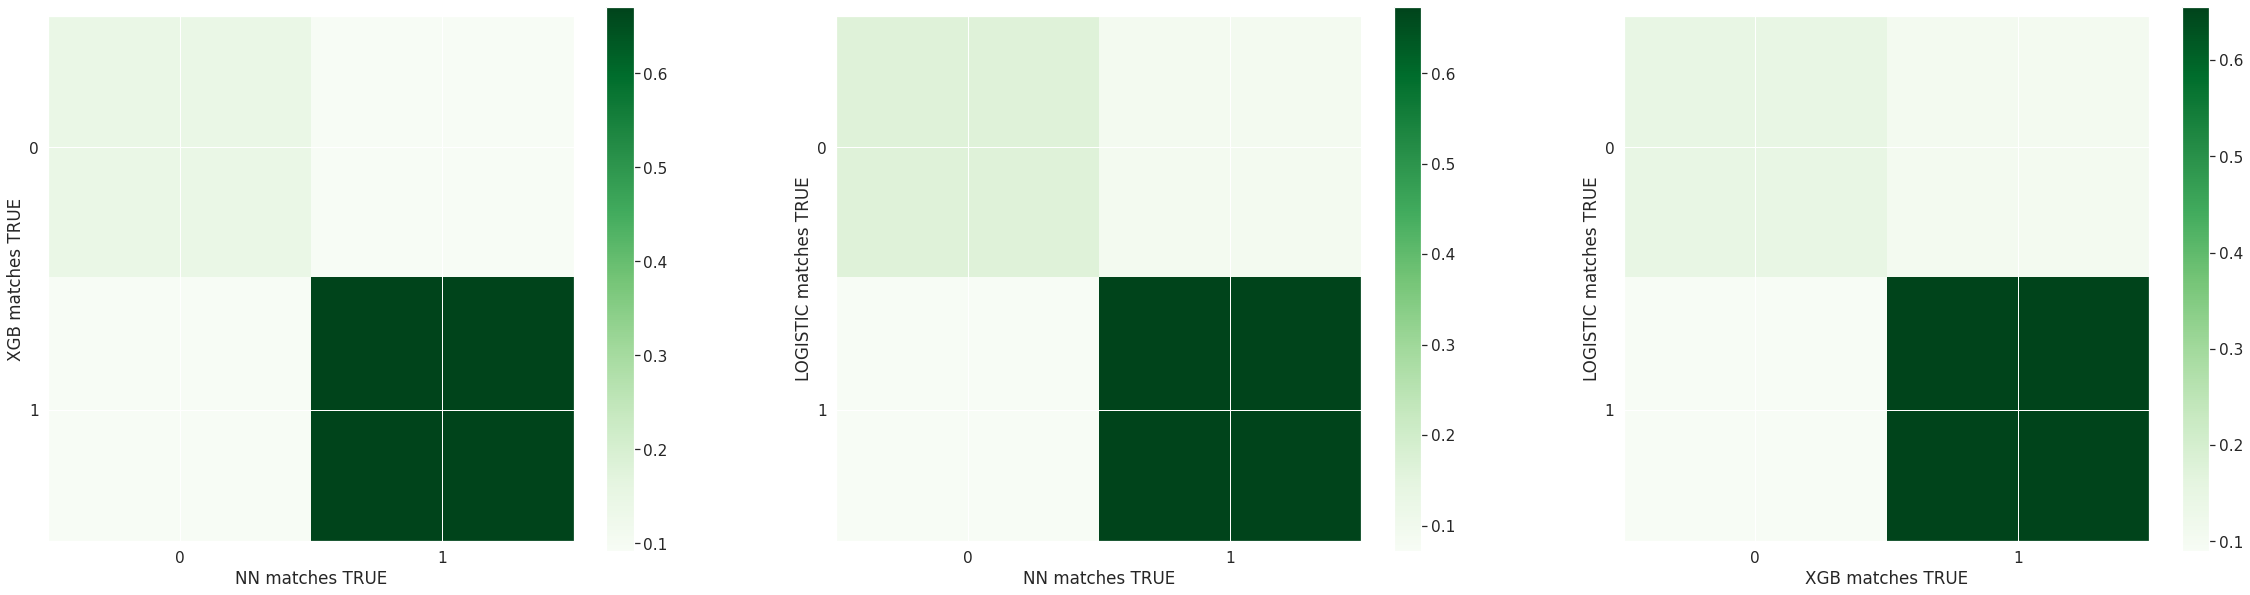

In [154]:
run_analysis(run_cv_analysis('../data/raw_output/cross_val/checkpoints/CROSS_VAL_paper_v1_w_ES/',
                             cross_val_predictions))

In [156]:
set([2, 3, 4, 5, 6]) - set([1, 2, 3, 4, 5])

{6}